***Importing libraries***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score

In [2]:
file_path_train = r'C:\Users\User\Desktop\Main\7 semester\ML\college.csv'
df_train = pd.read_csv(file_path_train)
df_train.head()

,type_school,school_accreditation,gender,interest,residence,parent_age,parent_salary,house_area,average_grades,parent_was_in_college,will_go_to_college
0,Academic,A,Male,Less Interested,Urban,56,6950000,83.0,84.09,False,True
1,Academic,A,Male,Less Interested,Urban,57,4410000,76.8,86.91,False,True
2,Academic,B,Female,Very Interested,Urban,50,6500000,80.6,87.43,False,True
3,Vocational,B,Male,Very Interested,Rural,49,6600000,78.2,82.12,True,True
4,Academic,A,Female,Very Interested,Urban,57,5250000,75.1,86.79,False,False


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   type_school            1000 non-null   object 
 1   school_accreditation   1000 non-null   object 
 2   gender                 1000 non-null   object 
 3   interest               1000 non-null   object 
 4   residence              1000 non-null   object 
 5   parent_age             1000 non-null   int64  
 6   parent_salary          1000 non-null   int64  
 7   house_area             1000 non-null   float64
 8   average_grades         1000 non-null   float64
 9   parent_was_in_college  1000 non-null   bool   
 10  will_go_to_college     1000 non-null   bool   
dtypes: bool(2), float64(2), int64(2), object(5)
memory usage: 72.4+ KB


***Data preprocessing***

In [4]:
df_train.describe()

,parent_age,parent_salary,house_area,average_grades
count,1000.000000,1.000000e+03,1000.000000,1000.000000
mean,52.208000,5.381570e+06,74.515300,86.097200
std,3.500427,1.397546e+06,15.293346,3.378738
min,40.000000,1.000000e+06,20.000000,75.000000
25%,50.000000,4.360000e+06,64.600000,83.737500
50%,52.000000,5.440000e+06,75.500000,85.575000
75%,54.000000,6.382500e+06,84.825000,88.262500
max,65.000000,1.000000e+07,120.000000,98.000000


In [5]:
df_train.isnull().sum()

type_school              0
school_accreditation     0
gender                   0
interest                 0
residence                0
parent_age               0
parent_salary            0
house_area               0
average_grades           0
parent_was_in_college    0
will_go_to_college       0
dtype: int64

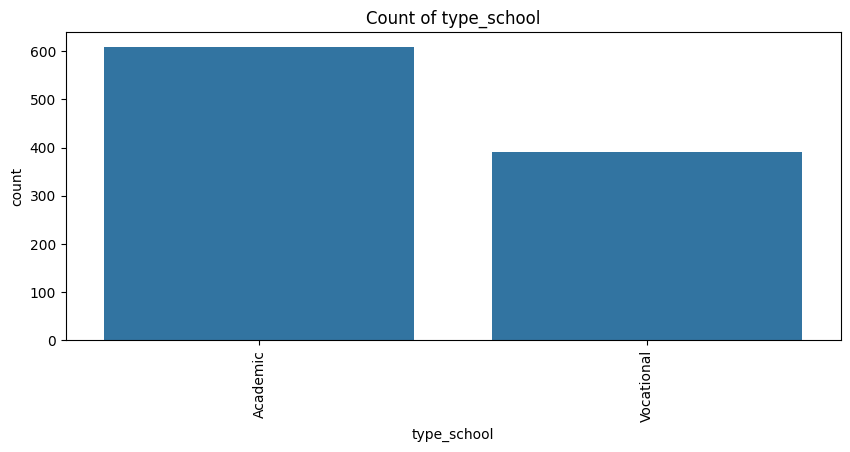

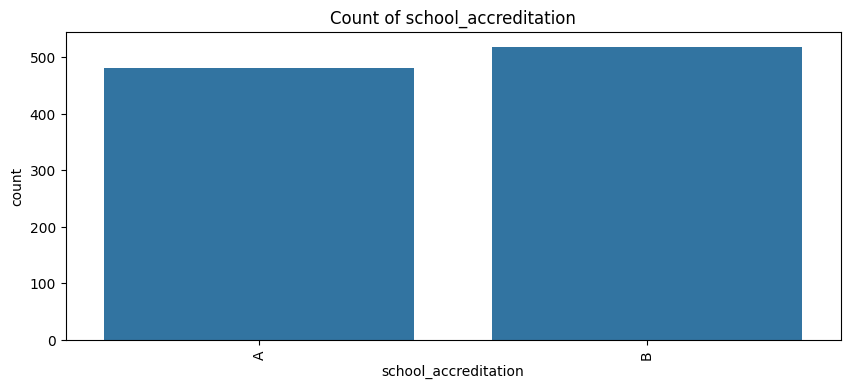

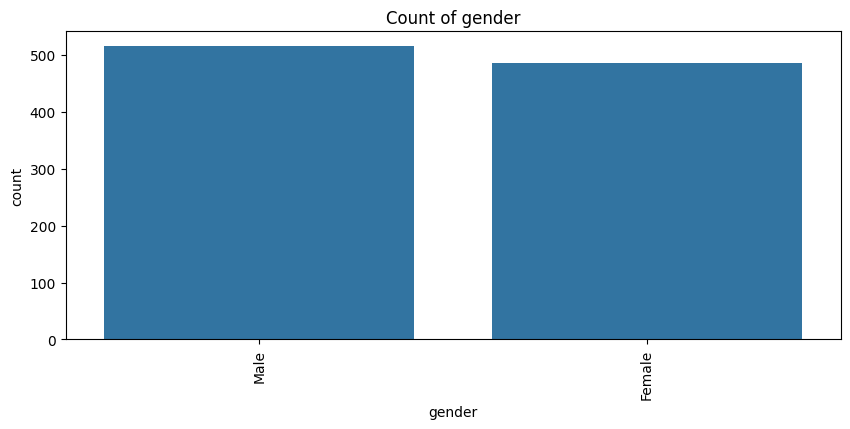

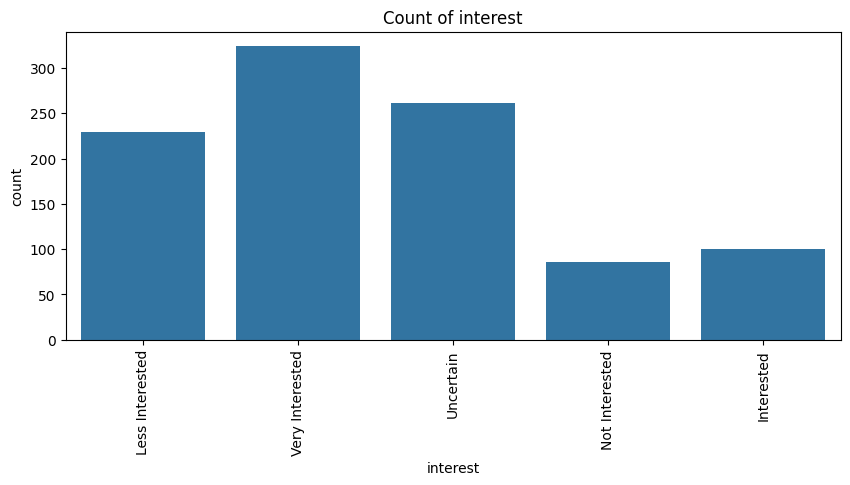

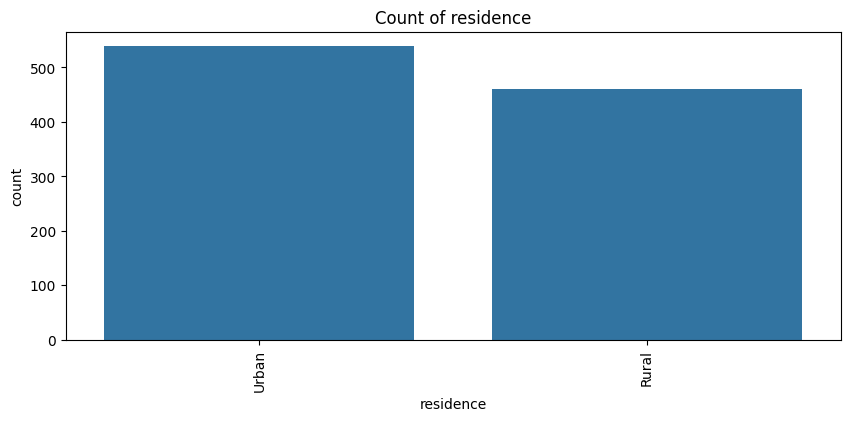

In [133]:
for column_name in df_train.columns:
    if df_train[column_name].dtype == 'object':
        plt.figure(figsize=(10, 4))  
        sns.countplot(x=column_name, data=df_train)
        plt.title(f'Count of {column_name}')
        plt.xticks(rotation=90) 
        plt.show()

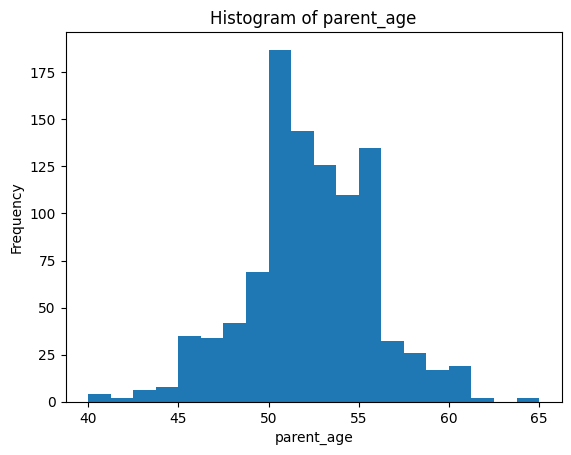

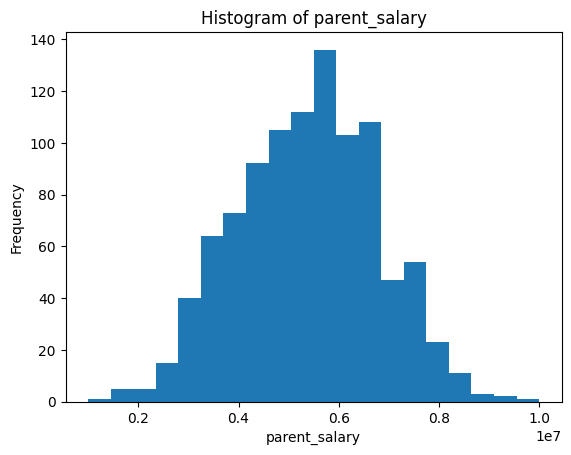

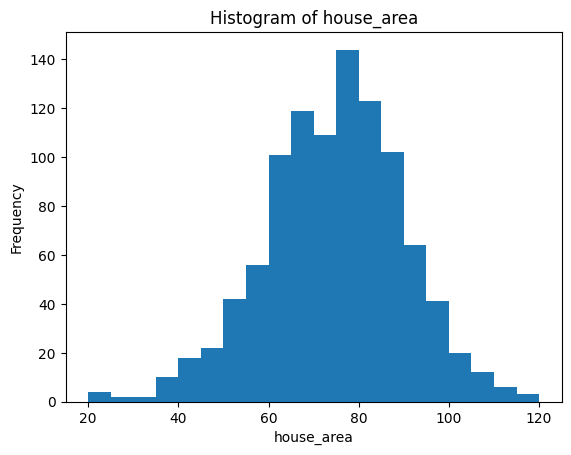

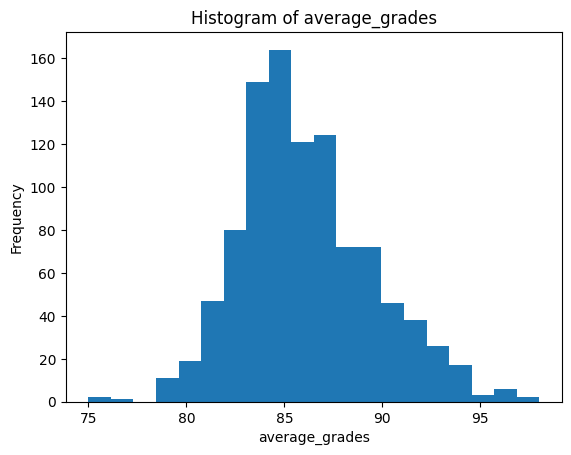

In [6]:
for column_name in df_train.columns:
    if df_train[column_name].dtype in ['int64', 'float64']:
        plt.hist(df_train[column_name], bins=20)
        plt.title(f'Histogram of {column_name}')
        plt.xlabel(column_name)
        plt.ylabel('Frequency')
        plt.show()

In [7]:
objects = df_train.select_dtypes(include = ['object', 'bool']).columns
for j in objects:
    df_train[j] = pd.factorize(df_train[j])[0]

In [8]:
X = df_train.iloc[:, :-1].values
Y = df_train.iloc[:, -1].values.reshape(-1,1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

***Handmade class***

In [9]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node
        self.value = value

In [32]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y)
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child):        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        return gain

    def gini_index(self, y):        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value(self, Y):        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def fit(self, X, Y):
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

In [33]:
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=5)
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test) 

# Calculating evaluation metrics
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy of the Decision tree classifier model: {accuracy}")

conf_m = confusion_matrix(y_test, predictions)
print(f"Confusion matrix of the Decision tree classifier model: {conf_m}")

r2 = r2_score(y_test, predictions)
print(f"R2 score of the Decision tree classifier model: {r2}")

Accuracy of the Decision tree classifier model: 0.8233333333333334
Confusion matrix of the Decision tree classifier model: [[119  30]
 [ 23 128]]
R2 score of the Decision tree classifier model: 0.29330192452997916


***Result from Sklearn***

In [19]:
from sklearn.tree import DecisionTreeClassifier

# Create a decision tree classifier
clf = DecisionTreeClassifier(random_state=42)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculating evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Decision tree classifier model: {accuracy}")

conf_m = confusion_matrix(y_test, y_pred)
print(f"Confusion matrix of the Decision tree classifier model: {conf_m}")

r2 = r2_score(y_test, y_pred)
print(f"R2 score of the Decision tree classifier model: {r2}")

Accuracy of the Decision tree classifier model: 0.84
Confusion matrix of the Decision tree classifier model: [[123  26]
 [ 22 129]]
R2 score of the Decision tree classifier model: 0.3599715542913019
